In [32]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import sys, os, random
import importlib
import numpy as np
from sklearn.metrics import make_scorer, recall_score, fbeta_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import ComplementNB

#Class Import
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../.."))) #Allow for imports from src
from src.models import QDA_Tester
from src.models import CNB_Tester
importlib.reload(QDA_Tester) #Ensures file is uptodate!
importlib.reload(CNB_Tester) 
from src.models.QDA_Tester import QDA_Class
from src.models.CNB_Tester import CNB_Class

#Set Seed
os.environ["PYTHONHASHSEED"] = "1945"
random.seed(1945)
np.random.seed(1945)

Personal Note: CNB_Tester & QDA_Tester do not have the arg save_plots. Instead calling show_plots=True automatically saves the figs to the Plots folder. This differs from other model optimization files. Additionally, not specific naming is done so figs will override existing figs in the Plots folder. 

In [33]:
#Complied data of convoys
#Routes examined are HX, SC, OB, ON, ONS
df = pd.read_csv('/Users/matthewplambeck/Desktop/Convoy Predictor/data/processed/Complete_Convoy_Data.csv')
df = df.drop(columns=['Unnamed: 0'])
df.shape #Test

(1174, 21)

In [34]:
#Drop unecessary/redundent features
df = df.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Number of Escorts Sunk', \
                         'Number of Stragglers Sunk', 'Total Tons of Ships Sunk', 'Escort Sink Percentage', 'Straggler Sink Percentage'])
df.reset_index(drop=True).head(3)

,Number of Ships,Number of Escort Ships,Number of Stragglers,Total Tons of Convoy,Overall Sink Percentage,Avg Number of U-Boats in Atlantic,Escort Ratio,Time At Sea (Days),Month,Year,Previous Month Avg Sink %,Approx. Sighting Range
0,5.0,2.0,0.0,22877.0,0.0,6.0,0.400000,3.0,9.0,1939.0,0.0,12.190200
1,5.0,2.0,0.0,22967.0,0.0,6.0,0.400000,5.0,9.0,1939.0,0.0,12.190200
2,7.0,4.0,0.0,21293.0,0.0,6.0,0.571429,5.0,9.0,1939.0,0.0,14.434062


In [35]:
#Convert Overall Sink Percentage to binary 1( High)
df['Risk'] = (df['Overall Sink Percentage'] > 0).astype(int) 
#Risk is binary based off whether a ship was sunk while in a convoy:  (0 = No Ships Sunk, 1 = At Least One Ship Sunk)
X = np.array(df.drop(columns=['Overall Sink Percentage', 'Risk'])) #Remove Overall Sink Percentage as it leaks data
y = df['Risk'].values #Prediction value

In [36]:
positive_label = 1  #at risk is 1
recall_scorers = {
    "recall_macro": "recall_macro",
    "recall_weighted": "recall_weighted",
    "recall_pos": make_scorer(recall_score, pos_label=positive_label),
    "f2_pos": make_scorer(fbeta_score, beta=2.0, pos_label=positive_label),}

In [46]:
cnb_grid1 = {"model__alpha": [0.1, 0.5, 1.0], "model__norm": [True, False]}

In [47]:
cnb_grid2 = {"model__alpha": [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5],
            "model__norm": [True, False],
            "model__fit_prior": [True, False],
            "model__class_prior": [None, [0.35, 0.65], [0.25, 0.75]]}


In [48]:
#Simple Param Grid Test
cnb = CNB_Class(parameter_grid=cnb_grid1, cv_folds=5, random_state=1945)
cnb.positive_label = positive_label
cnb.auto_calibrate_threshold = True
cnb.train_test_split(X, y)
cnb.optimize(scoring=recall_scorers, refit="recall_pos")
cnb_results = cnb.evaluate(show_plots=False, print_results=True)



Best Hyperparameters Found:
{'model__alpha': 0.1, 'model__norm': False}
Best CV (recall_pos): 0.6371
Applied decision threshold: 0.4896 (F-beta: 0.4876)

Pipeline Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.63      0.73       185
           1       0.34      0.70      0.45        50

    accuracy                           0.64       235
   macro avg       0.61      0.66      0.59       235
weighted avg       0.77      0.64      0.67       235


ROC AUC Score: 0.7054
Matthews Correlation Coefficient (MCC): 0.2695
Balanced Accuracy: 0.6635
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          116           69
Actual 1           15           35
Recall (positive=1): 0.7000
F2 Score: 0.5757
False Negatives: 15



Best Hyperparameters Found:
{'model__alpha': 0.01, 'model__class_prior': None, 'model__fit_prior': True, 'model__norm': False}
Best CV (recall_pos): 0.6371
Applied decision threshold: 0.4897 (F-beta: 0.4876)

Pipeline Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.63      0.74       185
           1       0.34      0.70      0.46        50

    accuracy                           0.65       235
   macro avg       0.61      0.67      0.60       235
weighted avg       0.77      0.65      0.68       235


ROC AUC Score: 0.7056
Matthews Correlation Coefficient (MCC): 0.2742
Balanced Accuracy: 0.6662
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          117           68
Actual 1           15           35
Recall (positive=1): 0.7000
F2 Score: 0.5776
False Negatives: 15

Pipeline Plots:

ROC Curve:


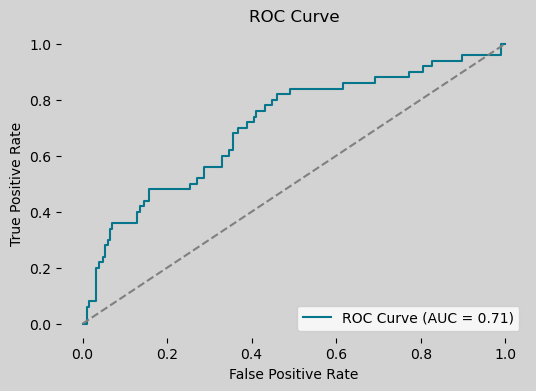

Precision-Recall Curve:


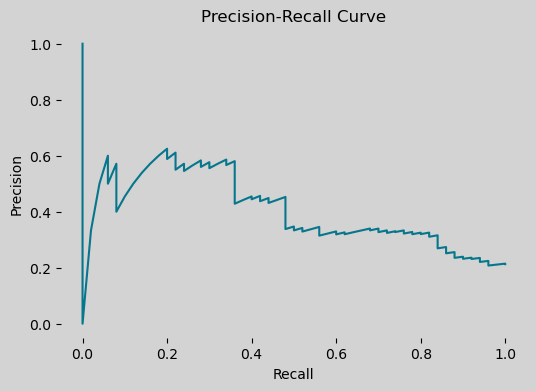

Confusion Matrix Heatmap:


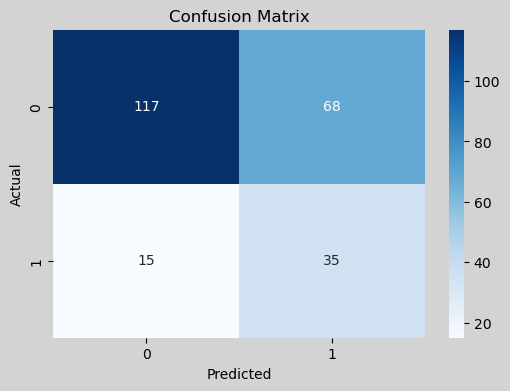

In [49]:
#More In Depth Param Grid Test
cnb2 = CNB_Class(parameter_grid=cnb_grid2, cv_folds=5, random_state=1945)
cnb2.positive_label = positive_label
cnb2.auto_calibrate_threshold = True
cnb2.train_test_split(X, y)
cnb2.optimize(scoring=recall_scorers, refit="recall_pos")
cnb_results2 = cnb2.evaluate(show_plots=True, print_results=True) #Save Plots here for Docs


In [50]:
#Threshold Test (Using In Depth Model)
thresholds = np.arange(0, 1.05, 0.05) 
thresholds = thresholds.tolist() 
rows = []

for t in thresholds:
    cnb2.set_decision_threshold(t)
    res = cnb2.evaluate(show_plots=False, print_results=False)
    rows.append({
        "threshold": t,
        "recall": res["recall"],
        "precision": res["classification_report"]["1"]["precision"],
        "false_negatives": res["false_negatives"],
        "accuracy": res["classification_report"]["accuracy"],
        "f1-scores": res["classification_report"]["macro avg"]["f1-score"]
        })
cnb2.set_decision_threshold(None) 
threshold_results = pd.DataFrame(rows)
threshold_results

/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

,threshold,recall,precision,false_negatives,accuracy,f1-scores
0,0.00,1.00,0.212766,0,0.212766,0.175439
1,0.05,1.00,0.212766,0,0.212766,0.175439
2,0.10,1.00,0.212766,0,0.212766,0.175439
3,0.15,1.00,0.212766,0,0.212766,0.175439
4,0.20,1.00,0.212766,0,0.212766,0.175439
5,0.25,1.00,0.212766,0,0.212766,0.175439
6,0.30,1.00,0.212766,0,0.212766,0.175439
7,0.35,1.00,0.212766,0,0.212766,0.175439
8,0.40,1.00,0.214592,0,0.221277,0.187374
9,0.45,0.86,0.255952,7,0.438298,0.435343


In [51]:
qda_grid1 =  {"model__reg_param": [0.0, 0.05, 0.15],"model__store_covariance": [False, True]}


In [52]:
qda_grid2 = {"model__reg_param": [0.0, 0.01, 0.03, 0.05, 0.1, 0.2, 0.3],
            "model__store_covariance": [False, True],
            "model__tol": [1e-4, 1e-3, 1e-2],
            "model__priors": [None, [0.92, 0.08], [0.85, 0.15], [0.80, 0.20]]}


In [53]:
#Simple Param Grid Test:
qda = QDA_Class(parameter_grid=qda_grid1, cv_folds=5, random_state=1945)
qda.positive_label = positive_label
qda.auto_calibrate_threshold = True
qda.threshold_beta = 2.0  #bias threshold search toward recall
qda.train_test_split(X, y)
qda.optimize(scoring=recall_scorers, refit="recall_pos")
qda_results = qda.evaluate(show_plots=False, print_results=True)



Best Hyperparameters Found:
{'model__reg_param': 0.0, 'model__store_covariance': False}
Best CV (recall_pos): 0.5918
Applied decision threshold: 0.1770 (F-beta: 0.6566)

Pipeline Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.52      0.67       185
           1       0.33      0.88      0.48        50

    accuracy                           0.60       235
   macro avg       0.64      0.70      0.58       235
weighted avg       0.81      0.60      0.63       235


ROC AUC Score: 0.7897
Matthews Correlation Coefficient (MCC): 0.3335
Balanced Accuracy: 0.7022
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0           97           88
Actual 1            6           44
Recall (positive=1): 0.8800
F2 Score: 0.6627
False Negatives: 6



Best Hyperparameters Found:
{'model__priors': None, 'model__reg_param': 0.0, 'model__store_covariance': False, 'model__tol': 0.0001}
Best CV (recall_pos): 0.5918
Applied decision threshold: 0.1770 (F-beta: 0.6566)

Pipeline Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.52      0.67       185
           1       0.33      0.88      0.48        50

    accuracy                           0.60       235
   macro avg       0.64      0.70      0.58       235
weighted avg       0.81      0.60      0.63       235


ROC AUC Score: 0.7897
Matthews Correlation Coefficient (MCC): 0.3335
Balanced Accuracy: 0.7022
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0           97           88
Actual 1            6           44
Recall (positive=1): 0.8800
F2 Score: 0.6627
False Negatives: 6

Pipeline Plots:

ROC Curve:


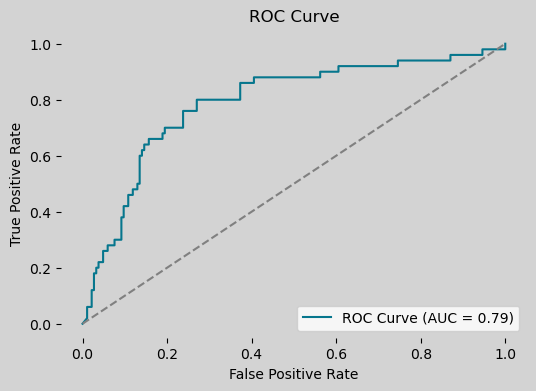

Precision-Recall Curve:


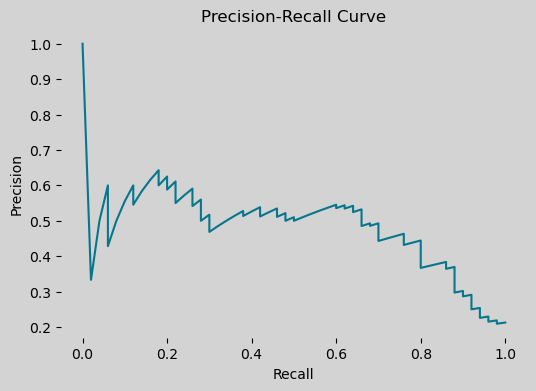

Confusion Matrix Heatmap:


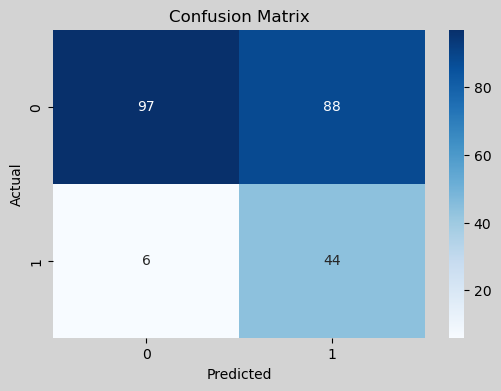

In [54]:
#More In Depth Param Grid Test
qda2 = QDA_Class(parameter_grid=qda_grid2, cv_folds=5, random_state=1945)
qda2.positive_label = positive_label
qda2.auto_calibrate_threshold = True
qda2.threshold_beta = 2.0  #bias threshold search toward recall
qda2.train_test_split(X, y)
qda2.optimize(scoring=recall_scorers, refit="recall_pos")
qda_results2 = qda2.evaluate(show_plots=True, print_results=True) #Save plots for the docs


In [55]:
thresholds = np.arange(0, 1.05, 0.05) 
thresholds = thresholds.tolist() 
rows = []

for t in thresholds:
    qda2.set_decision_threshold(t)
    res = qda2.evaluate(show_plots=False, print_results=False)
    rows.append({
        "threshold": t,
        "recall": res["recall"],
        "precision": res["classification_report"]["1"]["precision"],
        "false_negatives": res["false_negatives"],
        "accuracy": res["classification_report"]["accuracy"],
        "f1-scores": res["classification_report"]["macro avg"]["f1-score"]
        })
qda2.set_decision_threshold(None) 
threshold_results = pd.DataFrame(rows)
threshold_results

/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

,threshold,recall,precision,false_negatives,accuracy,f1-scores
0,0.00,1.00,0.212766,0,0.212766,0.175439
1,0.05,0.90,0.296053,5,0.523404,0.513817
2,0.10,0.88,0.303448,6,0.544681,0.531096
3,0.15,0.88,0.323529,6,0.582979,0.564024
4,0.20,0.88,0.343750,6,0.617021,0.593081
5,0.25,0.86,0.367521,7,0.655319,0.623822
6,0.30,0.80,0.370370,10,0.668085,0.628165
7,0.35,0.80,0.400000,10,0.702128,0.657292
8,0.40,0.80,0.434783,10,0.736170,0.687178
9,0.45,0.70,0.448718,15,0.753191,0.688642
